
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>
```
</p>

<a href="https://linkedin.com/in/lucasvazelle">Vazelle Lucas  </a> $\cdot$ 
<a href="https://www.linkedin.com/in/mariam-tarverdian">Taverdian Mariam </a> $\cdot$ 2024-2025, MOSEF $\cdot$ 


---


- [Projet Kaggel ](https://www.kaggle.com/competitions/mosef-bank-churn-prediction/)


In [126]:
import pandas as pd


# 1. Import data <a class="anchor" id="Introduction"></a>
---


In [127]:

train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print("Training Data:")
display(train.head())

print("Testing Data:")
display(test.head())

Training Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


Testing Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94


In [128]:
train.isnull().sum()
# pas de na

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [129]:
train.dtypes
# pas de surprises

id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

# 1. Premier traitement <a class="anchor" id="Introduction"></a>
---



1. enlever variables d'informations inutiles OK

2. gérer muticolinéarité OK 

3. encoder variable Gender Age (one hot encoding ou autre) OK

4. Outlier

5. créer des variables pertinentes (min max,..)

6. Si plusieurs observtion correspondent à la même personne et qu'il prends un gros poids, tout sera biaisé..il faut vérifier l'indépendances des observations

7. garder que colonnes que l'on comprends : RFE, BORUTA,..

8. CHoix métrique

## enlever variables d'information inutile

In [130]:
train_traitement = train.drop(columns=['Surname', 'id', 'CustomerId'])
# variables non pertinentes

In [131]:
train_traitement = train_traitement.drop_duplicates()
train_traitement.count()
# pas de doublons parfait 

CreditScore        15000
Geography          15000
Gender             15000
Age                15000
Tenure             15000
Balance            15000
NumOfProducts      15000
HasCrCard          15000
IsActiveMember     15000
EstimatedSalary    15000
Exited             15000
dtype: int64

## multicolinéarité

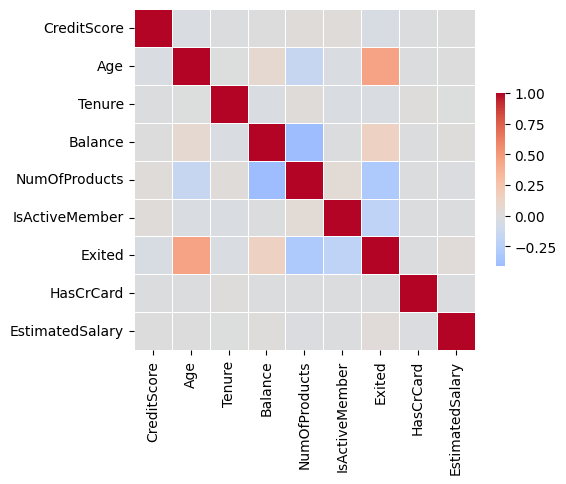

In [132]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

categorical_columns = ['Gender', 'Geography']
# Select only numeric columns
correlation_matrix = train_traitement.drop(columns=categorical_columns).corr()

# Compute the distance matrix
distance_matrix = 2 * (1 - np.abs(correlation_matrix))

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=3, linkage='single', metric="precomputed").fit(distance_matrix)

# Extract clusters
clusters = [list(correlation_matrix.columns[clustering.labels_ == lab]) for lab in set(clustering.labels_)]

# Reorder the correlation matrix
reordered = np.concatenate(clusters)
R = correlation_matrix.loc[reordered, reordered]

# Plot the heatmap
f, ax = plt.subplots(figsize=(5.5, 4.5))
_ = sns.heatmap(R, cmap='coolwarm', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [133]:
# enlève colonne balance car elle est très corrélé avec Nombre de produit mais nombre de produit est plus corrélé avec la target que Balance
train_traitement = train_traitement.drop(columns=['Balance'])
# remarque, c'est ce que fait Lasso

## outlier

Optimization terminated successfully.
         Current function value: 0.341519
         Iterations 7
Indices des outliers détectés : [    0    18    44 ... 14964 14971 14986]


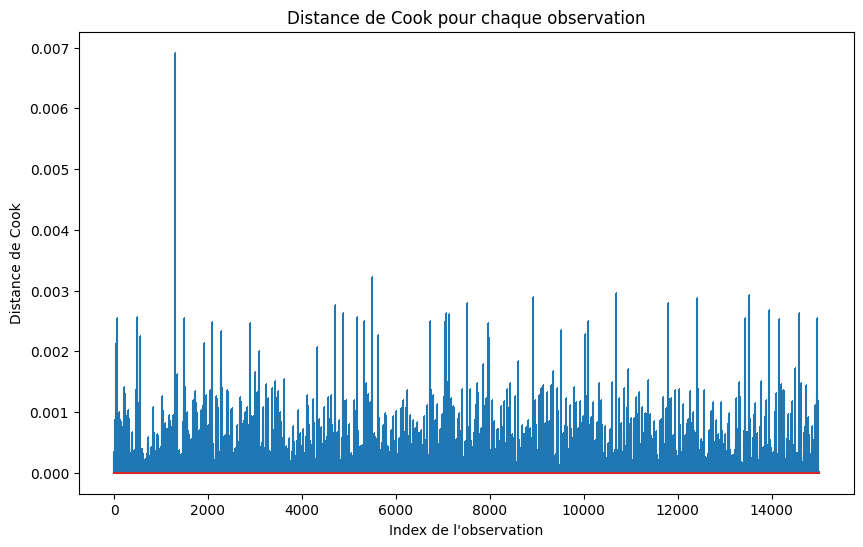

In [134]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt

class OutlierCooksDistance:
    def __init__(self, donnees: pd.DataFrame, variable_cible: str) -> None:
        self.donnees = donnees
        self.variable_cible = variable_cible
        self.colonnes_numeriques = donnees.select_dtypes(include=['float64', 'int64']).columns
        self.colonnes_categorielles = donnees.select_dtypes(include=['object']).columns
        self.variables_features = self.colonnes_numeriques.drop(variable_cible)
        self.X_features_numeriques = self.donnees[self.variables_features]
        self.y_cible = self.donnees[self.variable_cible]
        self.X_features_avec_constante = sm.add_constant(self.X_features_numeriques)

    def ajuster_modele_logistique(self):
        self.modele_logistique = sm.Logit(self.y_cible, self.X_features_avec_constante)
        self.modele_logistique_ajuste = self.modele_logistique.fit()

    def calculer_distances_cook(self):
        influence = self.modele_logistique_ajuste.get_influence()
        self.distances_cook = influence.cooks_distance[0]

    def identifier_outliers(self):
        nombre_observations = len(self.donnees)
        nombre_parametres = self.X_features_avec_constante.shape[1]
        seuil_distance_cook = 4 / (nombre_observations - nombre_parametres)
        self.outliers = np.where(self.distances_cook > seuil_distance_cook)[0]

    def supprimer_outliers(self) -> pd.DataFrame:
        if len(self.outliers) > 0:
            print(f"Indices des outliers détectés : {self.outliers}")
            self.donnees_sans_outliers = self.donnees.drop(index=self.outliers)
        else:
            print("Aucun outlier détecté. Pas de suppression d'observations.")
            self.donnees_sans_outliers = self.donnees
        return self.donnees_sans_outliers

    def tracer_distance_cook(self):
        plt.figure(figsize=(10, 6))
        plt.stem(np.arange(len(self.distances_cook)), self.distances_cook, markerfmt=",")
        plt.title("Distance de Cook pour chaque observation")
        plt.xlabel("Index de l'observation")
        plt.ylabel("Distance de Cook")
        plt.show()

# Exemple d'utilisation
data = train_traitement
variable_cible = 'Exited'
traitement = OutlierCooksDistance(data, variable_cible)
traitement.ajuster_modele_logistique()
traitement.calculer_distances_cook()
traitement.identifier_outliers()
data_train_sans_outlier = traitement.supprimer_outliers()
traitement.tracer_distance_cook()

In [146]:
print("nombre d'observations supprimées : ",)
len (train_traitement)  - len(data_train_sans_outlier)


nombre d'observations supprimées : 


1218

In [148]:
data_traitement = data_train_sans_outlier

## traitement catégorielles

In [149]:
train_traitement = pd.get_dummies(train_traitement, columns=['Gender', 'Geography'], drop_first=True)*1


# 2. Premier modèle <a class="anchor" id="Introduction"></a>
---


In [151]:
import statsmodels.api as sm

X = train_traitement.drop(columns=['Exited'])
y = train_traitement['Exited']

# Add a constant to the model
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())



Optimization terminated successfully.
         Current function value: 0.319142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                           10
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                  0.3610
Time:                        22:11:20   Log-Likelihood:                -4787.1
converged:                       True   LL-Null:                       -7492.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7432      0.299    -12.531      0.000      -4.329      -3.158
CreditSc

In [154]:

test_traitement = test.drop(columns=['Surname', 'id', 'CustomerId',"Balance"])
test_traitement = pd.get_dummies(test_traitement, columns=['Gender', 'Geography'], drop_first=True)*1
test_traitement = sm.add_constant(test_traitement)


In [155]:

test_predictions = logit_model.predict(test_traitement)
print(test_predictions)


0       0.232320
1       0.073524
2       0.043444
3       0.560649
4       0.198805
          ...   
9995    0.114571
9996    0.887390
9997    0.033561
9998    0.117674
9999    0.426286
Length: 10000, dtype: float64


In [158]:
# Create a new dataframe with 'id' and 'test_predictions'
test_predictions_df = pd.DataFrame({'id': test['id'], 'Predictions': test_predictions})

# Display the new dataframe
print(test_predictions_df.head())

      id  Predictions
0  15000     0.232320
1  15001     0.073524
2  15002     0.043444
3  15003     0.560649
4  15004     0.198805


In [159]:
# Save the test_predictions_df to a CSV file
test_predictions_df.to_csv('test_predictions.csv', index=False)

pycarest pour tester tous les modèles. 
LIGHT GBM
